### easyOCR 활용해서 글자 추출, 번역
참고: https://yunwoong.tistory.com/76

In [2]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

c:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [12]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list: # img가 리스트인 경우
        if type(title) == list: # 타이틀도 list인 경우
            titles = title
        else:
            titles = []
 
            for i in range(len(img)): # 타이틀이 list가 아닌 경우 타이틀 하나를 리스트로 만듦
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2: # 만약 2채널짜리라면
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB) # rgb로 만듦
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB) # 3채널 bgr이라면 rgb로 수정
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg) # rgb이미지 하나씩 출력
            plt.title(titles[i]) #title하나씩 출력
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else: # img가 리스트가 아닌 경우
        # 이미지가 3채널인지 아닌지 체크 후
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 그냥 출력
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
 
 
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  image = imutils.resize(image, width=width) # 이미지 리사이즈
  ratio = org_image.shape[1] / float(image.shape[1]) # 
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # bgr을 rgb로
  blurred = cv2.GaussianBlur(gray, ksize, 0) # 가우시안 블러 적용
  edged = cv2.Canny(blurred, min_threshold, max_threshold) # 엣지 검출
  # threshold1:minVal
  # 인수 설명의 전제로, Canny방법에서는 엣지를 하나의 긴 선으로 생각하므로, 엣지에 인접하고 있는 부분은 엣지가 되기 싶다
  # 즉, threshold1를 작은 값으로 설정하여도, 원래 주변에 아무것도 검출되지 않았던 부분에 갑자기 엣지가 검출되지는 않는다. 
  # 작은 값으로 설정하면, 원래 threshold2에 의해 검출된 엣지의 인접 부분이 엣지로 검출되기 쉬워져, 
  # 즉 직감적으로 얘기하자면 원래 threshold2에 의해서 검출된 엣지의 선을 길게 늘릴 뿐이다.
  #threshold2 : maxVal
  # threshold2의 쪽이 더욱 직감적인 값으로, 엣지인지 아닌지를 판단하는 임계값 그 자체이다. 


  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 컨투어스 찾아서 ..
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True) # 정렬
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2) # 상자 그림
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

In [13]:
# 한글 그리기 위한 함수
def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('./font/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)
 
  cv_img = np.array(img)
  
  return cv_img
#   옛날에 썼던 한글 그리기 함수
#   def textImage(img, string, x, y, fontsize, fontcolor=(0,0,0)):
    
#     pil_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # CV2를 RGB파일로
#     pil_image = Image.fromarray(pil_image) # PIL이미지로 변환

#     # 그리기 준비, 폰트 설정
#     fontpath = './font/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
#     font = ImageFont.truetype(fontpath, fontsize) # 폰트 종류, 크기 지정. 폰트 객체 생성
#     draw = ImageDraw.Draw(pil_image) # 그리기 객체 생성

#     draw.text((x, y), str(string), fontcolor, font=font) # 텍스트 그리기

#     return pil_image

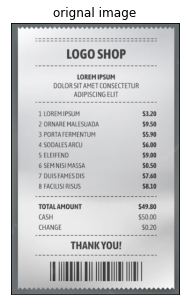

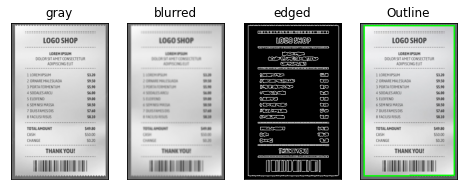

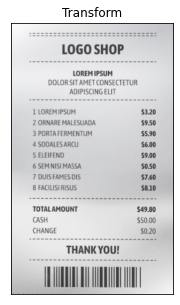

In [16]:

# url로 이미지 로드할 때
#image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
#org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 

org_image = cv2.imread('./imgs/re.jpg')
plt_imshow("orignal image", org_image)
 
receipt = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [18]:
# 텍스트 추출

langs = ['en'] # 그림 내에 있는 이미지들
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(receipt, detail=0) # detail=0으로 하면 인식된 글자가 list형태로 반환됨

[INFO] OCR'ing input image...
Progress: |██████--------------------------------------------| 12.1% Complete

KeyboardInterrupt: 

In [ ]:
# 글자 인식 부위에 박스 그리기
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))
 
	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(business_card_image, tl, br, (0, 255, 0), 2)
  business_card_image = putText(business_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)